# &#x1F4D1; &nbsp; <span style="color:red"> Reflections. Deep Learning. Lesson 6</span>

##   &#x1F916; &nbsp; <span style="color:red">Links</span>

Some Lesser-Known Deep Learning Libraries

http://blog.paralleldots.com/technology/deep-learning/lesser-known-deep-learning-libraries/?utm_content=buffer02038&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer

Backpropagation Algorithm http://ufldl.stanford.edu/wiki/index.php/Backpropagation_Algorithm

Manifold learning http://scikit-learn.org/stable/modules/manifold.html

Keras.Guide to the Sequential model https://keras.io/getting-started/sequential-model-guide/

TensorFlow for Deep Learning Research http://web.stanford.edu/class/cs20si/lectures/

Recurrent Neural Networks in Tensorflow II http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html

Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras

http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

Understanding Stateful LSTM Recurrent Neural Networks in Python with Keras

http://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

##   &#x1F916; &nbsp; <span style="color:red">Libraries</span>

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

In [2]:
import struct
import os
import numpy as np
import pandas as pd
import random
import string
import zipfile
from time import time

In [3]:
import tensorflow as tf
import keras as ks

Using TensorFlow backend.


In [4]:
from six.moves import range
from six.moves import cPickle
from six.moves.urllib.request import urlretrieve
import tensorflow.examples.tutorials.mnist as mnist

In [5]:
import nltk

In [6]:
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import cifar10, imdb

In [38]:
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [8]:
from IPython.display import display, Image
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
%matplotlib inline

##   &#x1F916; &nbsp; <span style="color:red"> Data </span>

In [9]:
mnist_data = mnist.input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
train_images = mnist_data.train.images
train_images.shape

(55000, 784)

In [11]:
train_labels = mnist_data.train.labels
train_labels.shape

(55000, 10)

In [12]:
train_labels2 = np.array([ np.where(r==1)[0][0] for r in train_labels])
train_labels2.shape

(55000,)

In [13]:
test_images = mnist_data.test.images
test_images.shape

(10000, 784)

In [14]:
test_labels = mnist_data.test.labels
test_labels.shape

(10000, 10)

In [15]:
test_labels2 = np.array([ np.where(r==1)[0][0] for r in test_labels])
test_labels2.shape

(10000,)

In [16]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' 
                                % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' 
                               % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                    dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [17]:
load_mnist('')
X_train, Y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, Y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [18]:
digits = datasets.load_digits(n_class=10)

X, y = digits.data, digits.target

In [19]:
X.shape

(1797, 64)

In [20]:
y.shape

(1797,)

In [21]:
n_samples, n_features = X.shape
n_neighbors = 30

In [22]:
r_x_train = np.random.random((100, 100, 100, 3))
r_y_train = ks.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
r_x_test = np.random.random((20, 100, 100, 3))
r_y_test = ks.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)

In [23]:
r_x_train.shape

(100, 100, 100, 3)

In [24]:
r_y_train.shape

(100, 10)

In [25]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = cPickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [26]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [27]:
def run_test(num_steps):

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [28]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [29]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [40]:
x_train.shape

(25000,)

In [ ]:
num_words3, max_length3, embedding_vector_length3 = 10000, 1000, 32
(x_train3, y_train3), (x_test3, y_test3) = imdb.load_data(num_words=num_words3)
x_train3 = sequence.pad_sequences(x_train3, maxlen=max_length3)
x_test3 = sequence.pad_sequences(x_test3, maxlen=max_length3)

In [30]:
(x_train2, y_train2), (x_test2, y_test2) = cifar100.load_data()

In [31]:
x_train2.shape

(50000, 32, 32, 3)

In [32]:
y_train2c = ks.utils.to_categorical(y_train2, num_classes=10)

In [33]:
y_train2c[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [34]:
y_test2c = ks.utils.to_categorical(y_test2, num_classes=10)

In [35]:
y_test2c.shape

(10000, 10)

In [ ]:
(x_train4, y_train4), (x_test4, y_test4) = cifar10.load_data()
print('x_train4 shape:', x_train4.shape)
print(x_train4.shape[0], 'train samples')
print(x_test4.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train4 = keras.utils.to_categorical(y_train4, num_classes)
y_test4 = keras.utils.to_categorical(y_test4, num_classes)

x_train4 = x_train4.astype('float32')
x_test4 = x_test4.astype('float32')
x_train4 /= 255
x_test4 /= 255

##   &#x1F916; &nbsp; <span style="color:red"> Software and Tools </span>

### Scikit-learn

#### Neural network models (supervised)

##### Multi-layer Perceptron

In [49]:
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=70, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
clf.fit(mnist_data.train.images, mnist_data.train.labels);

Iteration 1, loss = 0.60156824
Iteration 2, loss = 0.27297370
Iteration 3, loss = 0.20647665
Iteration 4, loss = 0.17051029
Iteration 5, loss = 0.14766734
Iteration 6, loss = 0.13066736
Iteration 7, loss = 0.11707463
Iteration 8, loss = 0.10379596
Iteration 9, loss = 0.09576563
Iteration 10, loss = 0.08580545
Iteration 11, loss = 0.07876979
Iteration 12, loss = 0.07143936
Iteration 13, loss = 0.06422787
Iteration 14, loss = 0.05865670
Iteration 15, loss = 0.05444742
Iteration 16, loss = 0.05104569
Iteration 17, loss = 0.04502452
Iteration 18, loss = 0.04091311
Iteration 19, loss = 0.03783826
Iteration 20, loss = 0.03472363
Iteration 21, loss = 0.03240190
Iteration 22, loss = 0.02882075
Iteration 23, loss = 0.02590460
Iteration 24, loss = 0.02426535
Iteration 25, loss = 0.02127423
Iteration 26, loss = 0.01985075
Iteration 27, loss = 0.01848932
Iteration 28, loss = 0.01739222
Iteration 29, loss = 0.01442560
Iteration 30, loss = 0.01318563
Iteration 31, loss = 0.01165906
Iteration 32, los

In [50]:
train_predict = clf.predict(mnist_data.train.images)
test_predict = clf.predict(mnist_data.test.images)

In [51]:
print("Train score: %f" % clf.score(mnist_data.train.images, mnist_data.train.labels))

Train score: 1.000000


In [52]:
print("Test score: %f" % clf.score(mnist_data.test.images, mnist_data.test.labels))

Test score: 0.955200


#####  Bernoulli Restricted Boltzmann machine

In [58]:
logistic = linear_model.LogisticRegression()
brbm = BernoulliRBM(random_state=0, verbose=True)
classifier = Pipeline(steps=[('brbm', brbm), ('logistic', logistic)])

In [59]:
brbm.learning_rate = 0.01
brbm.n_iter = 50
brbm.n_components = 128

In [60]:
classifier.fit(train_images, train_labels2)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -109.53, time = 14.53s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -95.96, time = 19.09s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -90.01, time = 18.33s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -86.53, time = 17.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -83.10, time = 17.12s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -81.59, time = 17.82s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -81.04, time = 18.06s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -79.26, time = 16.51s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -77.85, time = 16.18s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -78.41, time = 17.42s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -77.36, time = 16.82s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -76.75, time = 17.12s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -76.29, time = 16.93s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -76.38, time = 17.34s
[BernoulliRBM]

Pipeline(steps=[('brbm', BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=128, n_iter=50,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [61]:
print("Logistic regression using RBM features:\n%s\n" % (metrics.classification_report(test_labels2,
                                                         classifier.predict(test_images))))

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.97      0.98      0.98      1135
          2       0.95      0.92      0.94      1032
          3       0.93      0.93      0.93      1010
          4       0.95      0.95      0.95       982
          5       0.93      0.91      0.92       892
          6       0.96      0.97      0.96       958
          7       0.95      0.93      0.94      1028
          8       0.92      0.93      0.93       974
          9       0.92      0.92      0.92      1009

avg / total       0.95      0.95      0.95     10000




In [38]:
logistic_classifier = linear_model.LogisticRegression()
logistic_classifier.fit(train_images, train_labels2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
print("Logistic regression using raw pixel features:\n%s\n" % (metrics.classification_report(test_labels2,
                                                               logistic_classifier.predict(test_images))))

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.96      0.98      0.97      1135
          2       0.94      0.89      0.91      1032
          3       0.90      0.91      0.90      1010
          4       0.92      0.93      0.92       982
          5       0.89      0.86      0.88       892
          6       0.94      0.95      0.94       958
          7       0.93      0.92      0.93      1028
          8       0.88      0.87      0.87       974
          9       0.90      0.89      0.90      1009

avg / total       0.92      0.92      0.92     10000




In [222]:
# http://scikit-learn.org/stable/auto_examples/manifold/
# plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

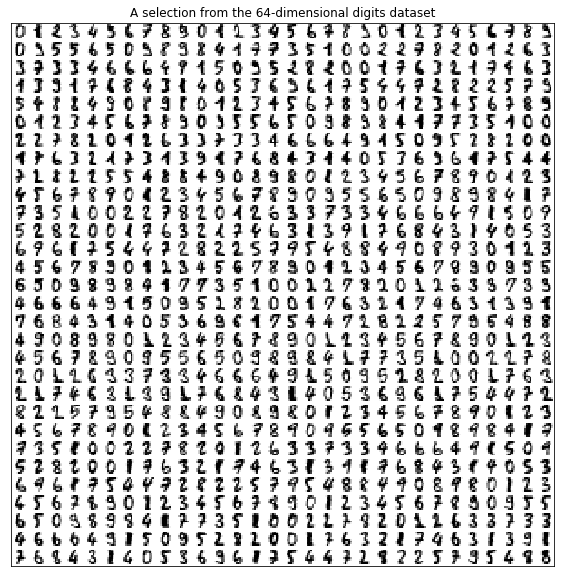

In [223]:
n_img_per_row = 30
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(10,10))
plt.imshow(img, cmap=plt.cm.binary)

plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

Computing random projection


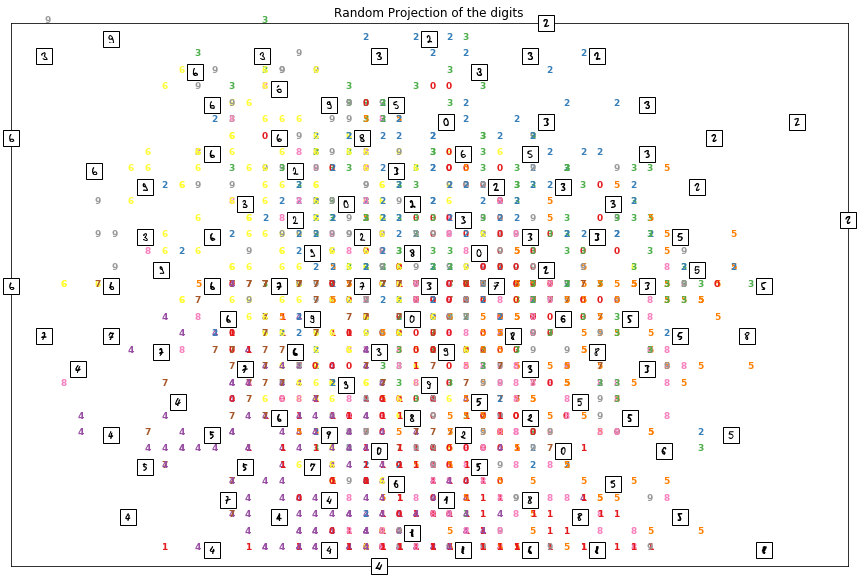

In [224]:
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

Computing PCA projection


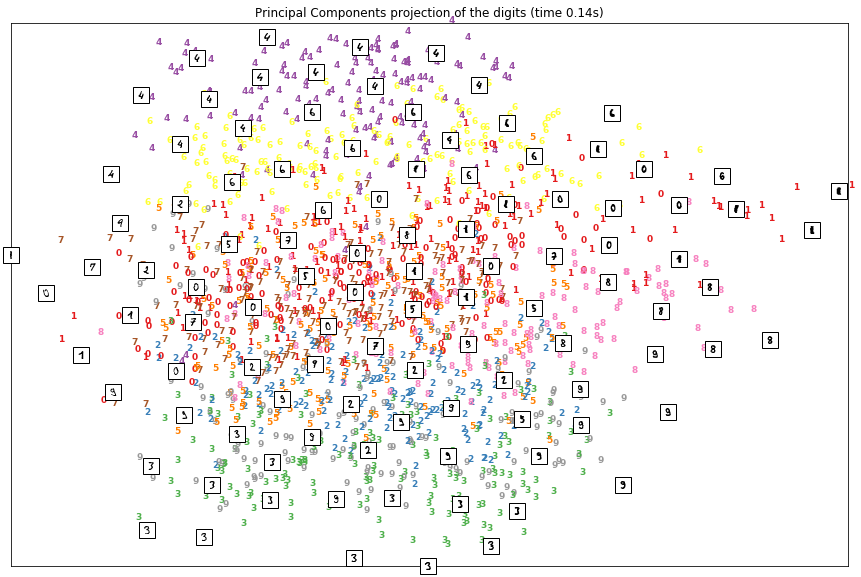

In [225]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, "Principal Components projection of the digits (time %.2fs)" % (time() - t0))

Computing Linear Discriminant Analysis projection


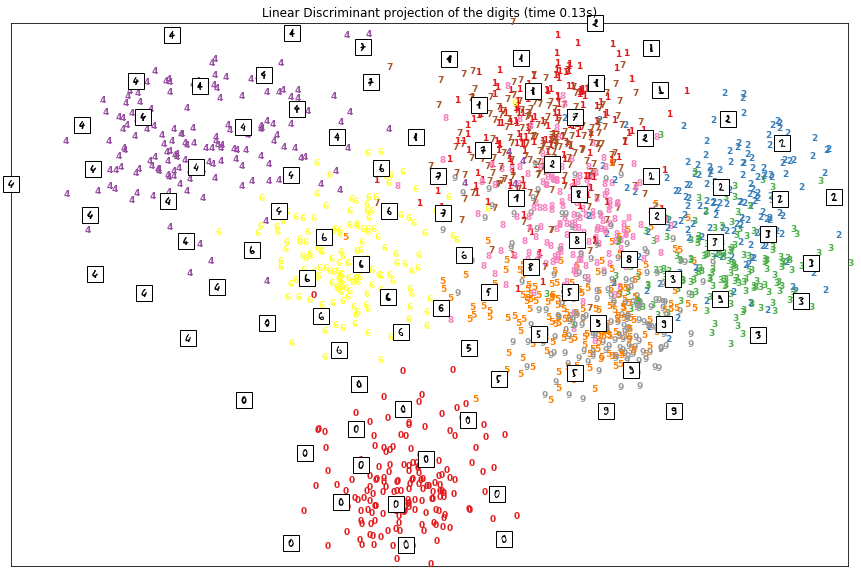

In [226]:
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, "Linear Discriminant projection of the digits (time %.2fs)" % (time() - t0))

Computing Totally Random Trees embedding


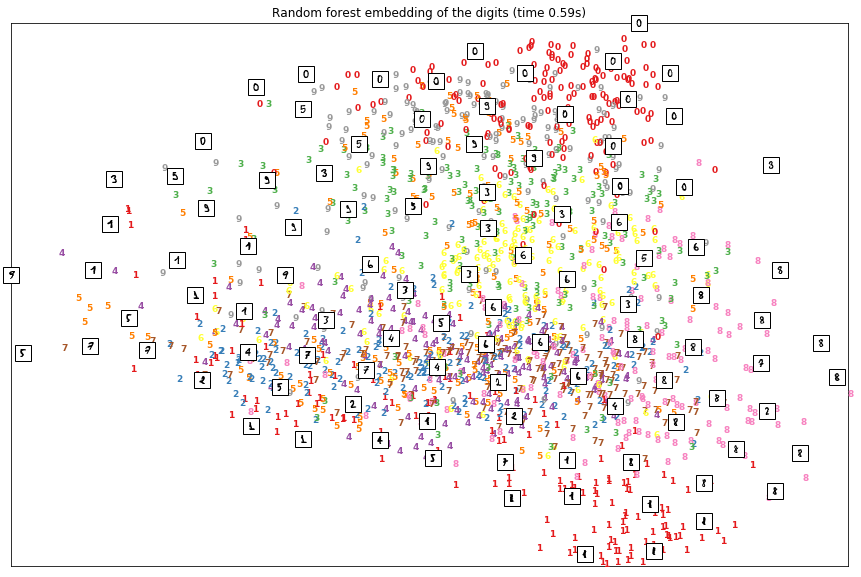

In [227]:
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Random forest embedding of the digits (time %.2fs)" % (time() - t0))

/Users/olgabelitskaya/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


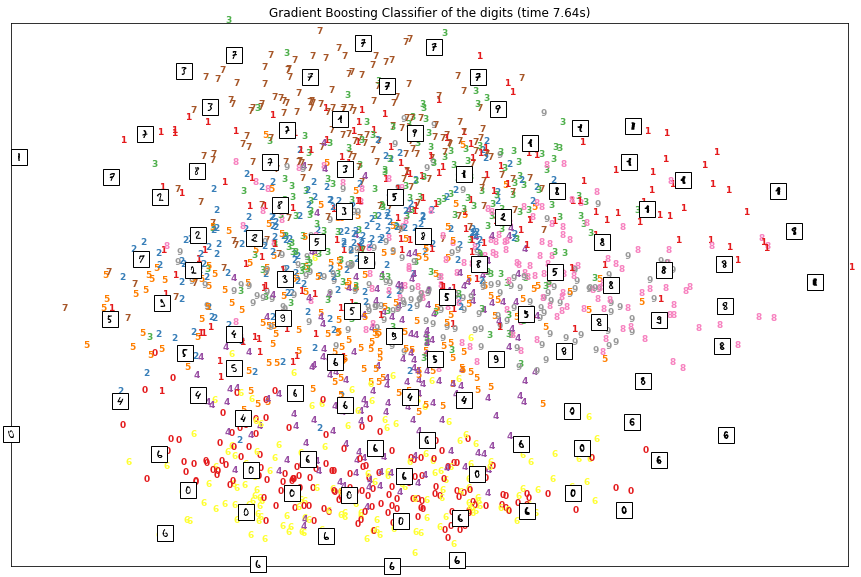

In [228]:
# Gradient Boosting Classifier of the digits dataset

gbc = ensemble.GradientBoostingClassifier(n_estimators=200, random_state=0, max_depth=5)
t0 = time()
X_transformed = gbc.fit_transform(X,y)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Gradient Boosting Classifier of the digits (time %.2fs)" % (time() - t0))

/Users/olgabelitskaya/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


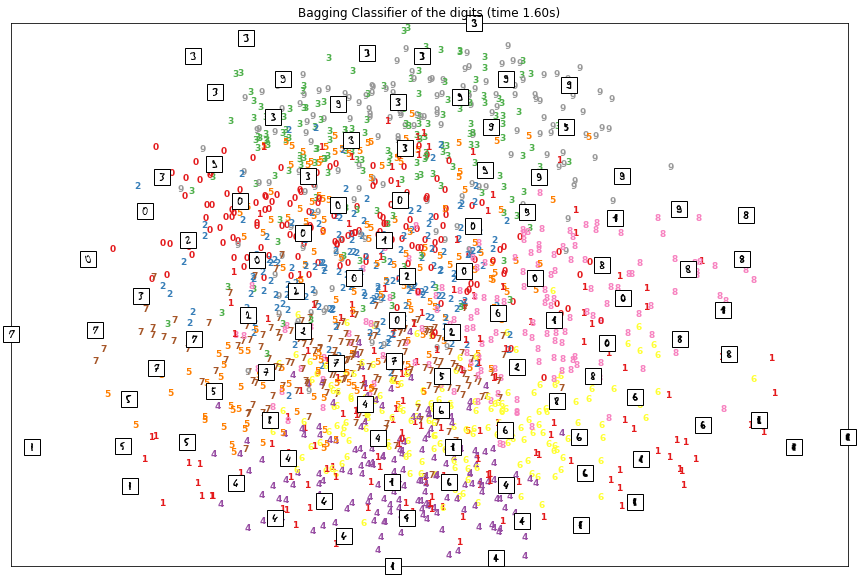

In [229]:
# Extra Trees Classifier of the digits dataset

etc = ensemble.ExtraTreesClassifier(n_estimators=300, random_state=0)
t0 = time()
X_transformed = etc.fit_transform(X,y)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced, "Bagging Classifier of the digits (time %.2fs)" % (time() - t0))

Computing Isomap embedding
Done.


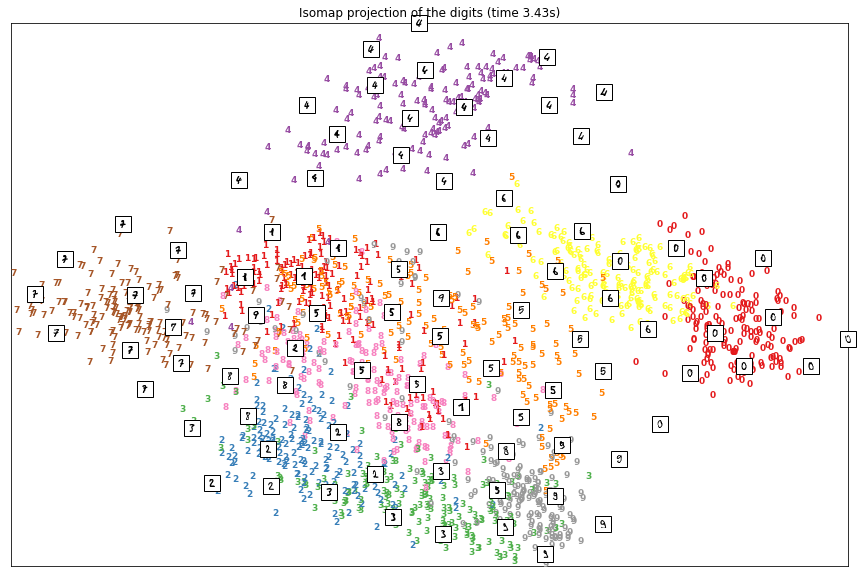

In [231]:
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso, "Isomap projection of the digits (time %.2fs)" % (time() - t0))

Computing LLE embedding
Done. Reconstruction error: 5.16179e-07


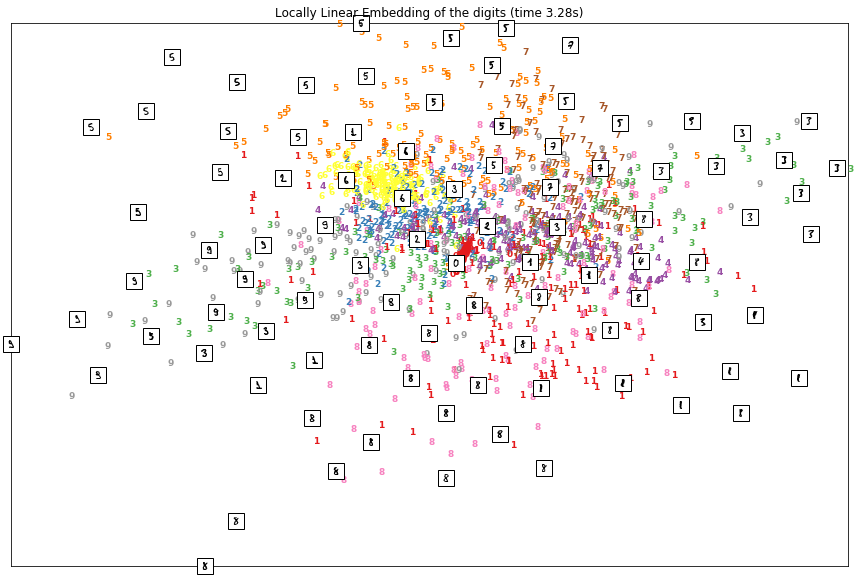

In [232]:
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle, "Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

Computing modified LLE embedding
Done. Reconstruction error: 0.561566


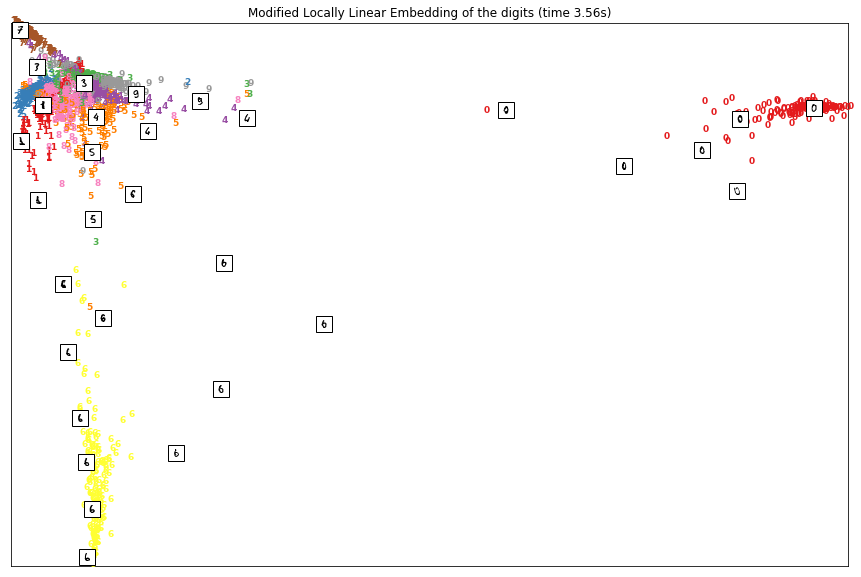

In [233]:
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle, "Modified Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

Computing Hessian LLE embedding
Done. Reconstruction error: 0.343078


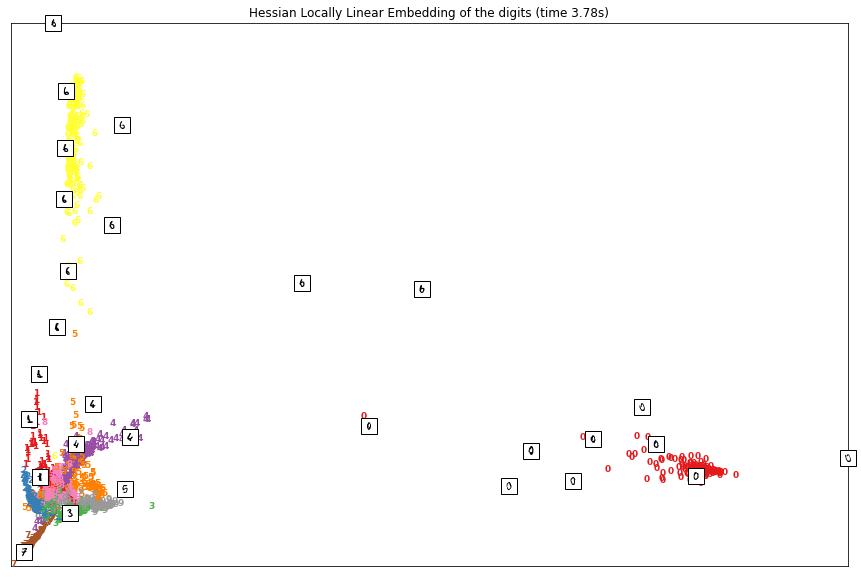

In [234]:
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle, "Hessian Locally Linear Embedding of the digits (time %.2fs)" % (time() - t0))

Computing LTSA embedding
Done. Reconstruction error: 0.343084


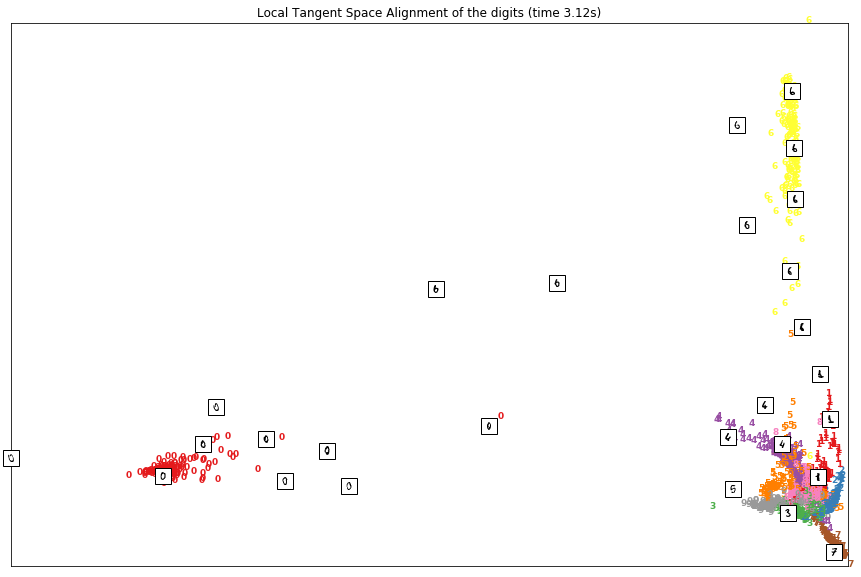

In [235]:
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa, "Local Tangent Space Alignment of the digits (time %.2fs)" % (time() - t0))

Computing MDS embedding
Done. Stress: 475436008.053272


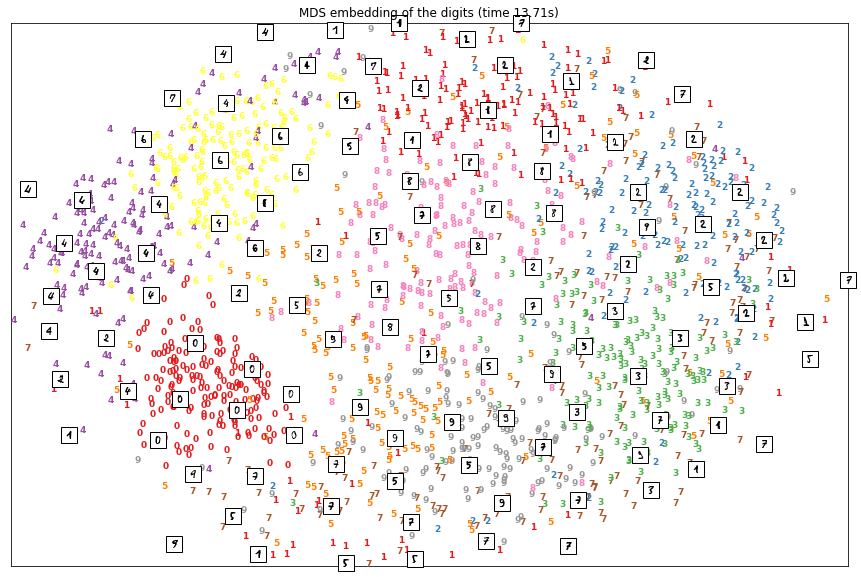

In [236]:
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds, "MDS embedding of the digits (time %.2fs)" % (time() - t0))

Computing Spectral embedding


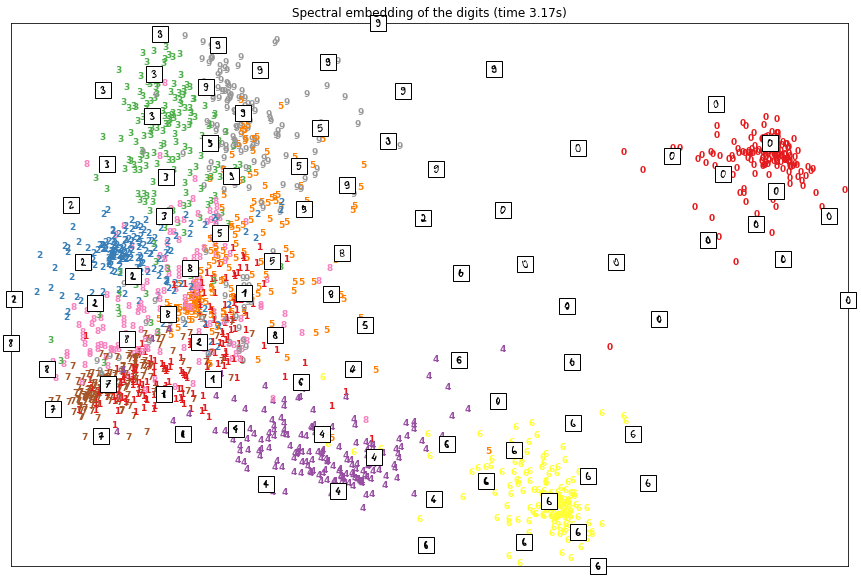

In [237]:
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se, "Spectral embedding of the digits (time %.2fs)" % (time() - t0))

Computing t-SNE embedding


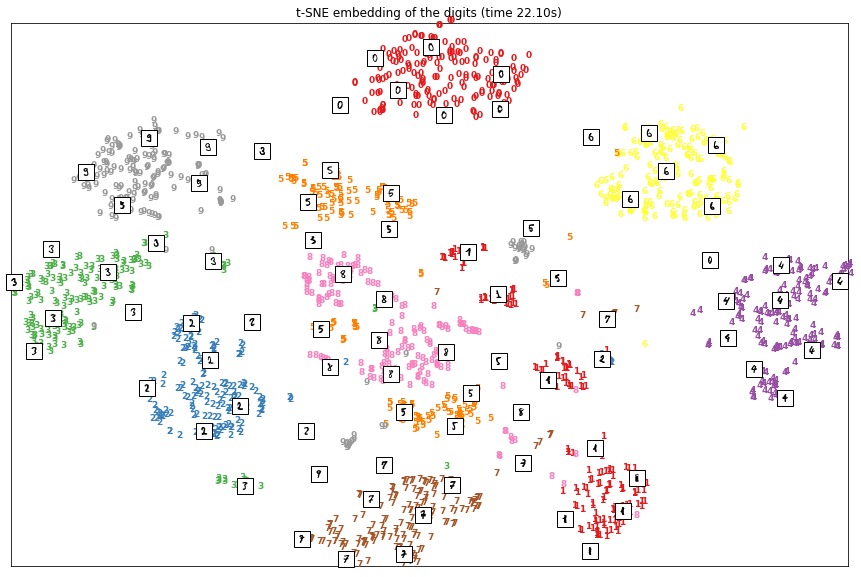

In [238]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" % (time() - t0))

### TensorFlow

- tf.TextLineReader
  - Outputs the lines of a file delimited by newlines
  - E.g. text files, CSV files

- tf.FixedLengthRecordReader
  - Outputs the entire file when all files have same fixed lengths
  - E.g. each MNIST file has 28 x 28 pixels, CIFAR-10 32 x 32 x 3

- tf.WholeFileReader
  - Outputs the entire file content

- tf.TFRecordReader
  - Reads samples from TensorFlow's own binary format (TFRecord)
  - tf.ReaderBase
  - Allows you to create your own readers

In [36]:
batch_size = 256
hidden_nodes = 1024
parameter = 0.0005 
dropout = 0.75

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights5 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights6 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights7 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights8 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights9 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights10 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights11 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights12 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights13 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights14 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights15 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights16 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    
    
    biases1 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases3 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases4 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases5 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases6 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases7 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases8 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases9 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases10 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases11 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases12 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases13 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases14 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases15 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))        
    biases16 = tf.Variable(tf.constant(0.05, shape=[num_labels]))
    
    # Training computation with Dropout.   
    
    train_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), dropout)
    train_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden1, weights2) + biases2), dropout)
    train_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden2, weights3) + biases3), dropout)
    train_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden3, weights4) + biases4), dropout)
    train_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden4, weights5) + biases5), dropout)
    train_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden5, weights6) + biases6), dropout)
    train_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden6, weights7) + biases7), dropout)
    train_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden7, weights8) + biases8), dropout)
    train_hidden9 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden8, weights9) + biases9), dropout)
    train_hidden10 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden9, weights10) + biases10), dropout)
    train_hidden11 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden10, weights11) + biases11), dropout)
    train_hidden12 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden11, weights12) + biases12), dropout)    
    train_hidden13 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden12, weights13) + biases13), dropout)
    train_hidden14 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden13, weights14) + biases14), dropout)
    train_hidden15 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden14, weights15) + biases15), dropout)    
    train_logits = tf.matmul(train_hidden15, weights16) + biases16
    
    valid_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), dropout)
    valid_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden1, weights2) + biases2), dropout)
    valid_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden2, weights3) + biases3), dropout)
    valid_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden3, weights4) + biases4), dropout)
    valid_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden4, weights5) + biases5), dropout)
    valid_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden5, weights6) + biases6), dropout)
    valid_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden6, weights7) + biases7), dropout)
    valid_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden7, weights8) + biases8), dropout)
    valid_hidden9 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden8, weights9) + biases9), dropout)
    valid_hidden10 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden9, weights10) + biases10), dropout)
    valid_hidden11 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden10, weights11) + biases11), dropout)
    valid_hidden12 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden11, weights12) + biases12), dropout)
    valid_hidden13 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden12, weights13) + biases13), dropout)
    valid_hidden14 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden13, weights14) + biases14), dropout)
    valid_hidden15 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden14, weights15) + biases15), dropout)      
    valid_logits = tf.matmul(valid_hidden15, weights16) + biases16
    
    test_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), dropout)
    test_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden1, weights2) + biases2), dropout)
    test_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden2, weights3) + biases3), dropout)
    test_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden3, weights4) + biases4), dropout)
    test_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden4, weights5) + biases5), dropout)
    test_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden5, weights6) + biases6), dropout)
    test_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden6, weights7) + biases7), dropout)
    test_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden7, weights8) + biases8), dropout)
    test_hidden9 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden8, weights9) + biases9), dropout)
    test_hidden10 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden9, weights10) + biases10), dropout)
    test_hidden11 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden10, weights11) + biases11), dropout)
    test_hidden12 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden11, weights12) + biases12), dropout)
    test_hidden13 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden12, weights13) + biases13), dropout)    
    test_hidden14 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden13, weights14) + biases14), dropout)
    test_hidden15 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden14, weights15) + biases15), dropout)  
    test_logits = tf.matmul(test_hidden15, weights16) + biases16
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) \
    + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2) \
    + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(biases3) \
    + tf.nn.l2_loss(weights4) + tf.nn.l2_loss(biases4) \
    + tf.nn.l2_loss(weights5) + tf.nn.l2_loss(biases5) \
    + tf.nn.l2_loss(weights6) + tf.nn.l2_loss(biases6) \
    + tf.nn.l2_loss(weights7) + tf.nn.l2_loss(biases7) \
    + tf.nn.l2_loss(weights8) + tf.nn.l2_loss(biases8) \
    + tf.nn.l2_loss(weights9) + tf.nn.l2_loss(biases9) \
    + tf.nn.l2_loss(weights10) + tf.nn.l2_loss(biases10) \
    + tf.nn.l2_loss(weights11) + tf.nn.l2_loss(biases11) \
    + tf.nn.l2_loss(weights12) + tf.nn.l2_loss(biases12) \
    + tf.nn.l2_loss(weights13) + tf.nn.l2_loss(biases13) \
    + tf.nn.l2_loss(weights14) + tf.nn.l2_loss(biases14) \
    + tf.nn.l2_loss(weights15) + tf.nn.l2_loss(biases15) \
    + tf.nn.l2_loss(weights16) + tf.nn.l2_loss(biases16)
    
    loss += parameter * regularizers    
  
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)    
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)    

In [37]:
run_test(10001)

Initialized
Minibatch loss at step 0: 18.605057
Minibatch accuracy: 9.0%
Validation accuracy: 10.1%
Minibatch loss at step 500: 9.617640
Minibatch accuracy: 9.8%
Validation accuracy: 10.9%
Minibatch loss at step 1000: 9.005987
Minibatch accuracy: 27.3%
Validation accuracy: 23.5%
Minibatch loss at step 1500: 8.332605
Minibatch accuracy: 45.7%
Validation accuracy: 43.5%
Minibatch loss at step 2000: 7.734032
Minibatch accuracy: 70.7%
Validation accuracy: 71.0%
Minibatch loss at step 2500: 7.303582
Minibatch accuracy: 80.1%
Validation accuracy: 79.6%
Minibatch loss at step 3000: 7.106730
Minibatch accuracy: 80.9%
Validation accuracy: 81.8%
Minibatch loss at step 3500: 6.791549
Minibatch accuracy: 85.2%
Validation accuracy: 82.7%
Minibatch loss at step 4000: 6.613572
Minibatch accuracy: 86.3%
Validation accuracy: 83.6%
Minibatch loss at step 4500: 6.528261
Minibatch accuracy: 82.4%
Validation accuracy: 83.8%
Minibatch loss at step 5000: 6.351035
Minibatch accuracy: 85.5%
Validation accuracy

### Keras

##### Multi-layer Perceptron

In [50]:
mlp_model = Sequential()

In [46]:
train_images.shape

(55000, 784)

In [48]:
test_images.shape

(10000, 784)

In [53]:
mlp_model.add(Dense(64, activation='relu', input_dim=784))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

mlp_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

mlp_model.fit(train_images, train_labels, epochs=20, batch_size=128)

mlp_score = mlp_model.evaluate(test_images, test_labels, batch_size=128)

Epoch 1/20
55000/55000 [==============================] - 3s - loss: 1.0971 - acc: 0.7099     
Epoch 2/20
55000/55000 [==============================] - 3s - loss: 0.5557 - acc: 0.8795     
Epoch 3/20
55000/55000 [==============================] - 3s - loss: 0.5034 - acc: 0.8903     
Epoch 4/20
55000/55000 [==============================] - 3s - loss: 0.4920 - acc: 0.8907     
Epoch 5/20
55000/55000 [==============================] - 3s - loss: 0.4611 - acc: 0.8965     
Epoch 6/20
55000/55000 [==============================] - 2s - loss: 0.4412 - acc: 0.8990     
Epoch 7/20
55000/55000 [==============================] - 2s - loss: 0.4399 - acc: 0.8997     
Epoch 8/20
55000/55000 [==============================] - 2s - loss: 0.4296 - acc: 0.9022     
Epoch 9/20
55000/55000 [==============================] - 2s - loss: 0.4203 - acc: 0.9037     
Epoch 10/20
55000/55000 [==============================] - 2s - loss: 0.4078 - acc: 0.9082     
Epoch 11/20
55000/55000 [========================

In [54]:
mlp_score

[0.17249117684364318, 0.9577]

##### LSTM

In [24]:
ks.backend.backend()

'tensorflow'

In [ ]:
lstm_model = Sequential()

lstm_model.add(Embedding(num_words3, embedding_vector_length3, input_length=max_length3))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

lstm_model.fit(x_train3, y_train3, validation_data=(x_test3, y_test3), epochs=3, batch_size=64)

In [ ]:
lstm_scores = lstm_model.evaluate(x_test3, y_test3, verbose=0)

##### VGG-like convnet

In [ ]:
batch_size = 32
num_classes = 10
epochs = 200

In [ ]:

vgg_model = Sequential()

vgg_model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train4.shape[1:]))
vgg_model.add(Activation('relu'))
vgg_model.add(Conv2D(32, (3, 3)))
vgg_model.add(Activation('relu'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))
vgg_model.add(Dropout(0.25))

vgg_model.add(Conv2D(64, (3, 3), padding='same'))
vgg_model.add(Activation('relu'))
vgg_model.add(Conv2D(64, (3, 3)))
vgg_model.add(Activation('relu'))
vgg_model.add(MaxPooling2D(pool_size=(2, 2)))
vgg_model.add(Dropout(0.25))

vgg_model.add(Flatten())
vgg_model.add(Dense(512))
vgg_model.add(Activation('relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(num_classes))
vgg_model.add(Activation('softmax'))

opt = ks.optimizers.rmsprop(lr=0.0001, decay=1e-6)

vgg_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
vgg_model.fit(x_train4, y_train4, batch_size=batch_size, epochs=epochs, 
              validation_data=(x_test4, y_test4), shuffle=True)

In [ ]:
vgg_scores = vgg_model.evaluate(x_test4, y_test4, verbose=0)